# Scalable Unsupervised Outlier Detection (SUOD)

----

**Created by**:

- **Author**: Dr. Saad Laouadi
- **Date**: 12/08/2024

This notebook was created by dr. Saad Laouadi on August 11th, 2024 as part of a series on anomaly detection algorithms. The content is designed for researchers, data scientists, and practitioners interested in applying the ECOD algorithm to identify anomalies in diverse datasets.

**Copyright**

**© 2024 Dr. Saad Laouadi. All rights reserved.**

---

## Table of Contents

1. [Objective](#Objective)
2. [Prerequisites](#Prerequisites)
3. [Theoretical Background of SUOD](#theoretical-background-of-suod)
   - 3.1. [Ensemble Learning Theory](#ensemble-learning-theory)
   - 3.2. [Dimensionality Reduction](#dimensionality-reduction)
   - 3.3. [Approximation Theory](#approximation-theory)
4. [Mathematical Framework](#mathematical-framework)
   - 4.1. [Ensemble Outlier Score](#ensemble-outlier-score)
   - 4.2. [Random Projection](#random-projection)
   - 4.3. [Pseudo-supervised Approximation](#pseudo-supervised-approximation)
5. [Computational Complexity](#computational-complexity)
6. [Training SUOD with PYOD](#training-suod-with-pyod)
   - 6.1. [Installing the SUOD Module](#installing-the-suod-module)
   - 6.2. [Key Parameters of SUOD](#key-parameters-of-suod)
   - 6.3. [Methods in SUOD](#methods-in-suod)
     - 6.3.1. [fit()](#fit)
     - 6.3.2. [predict()](#predict)
     - 6.3.3. [decision_function()](#decision_function)
   - 6.4. [Training SUOD Workflow](#training-suod-workflow)
7. [Practical Example of SUOD System with Simulated Data](#practical-example-of-suod-system-with-simulated-data)
8. [Real-World Example](#real-world-example)
   - 8.1. [SUOD System Workflow](#suod-system-workflow)
      - 8.1.1. [Data Preprocessing](#data-preprocessing)
      - 8.1.2. [SUOD Application](#suod-application)
      - 8.1.3. [Performance Evaluation](#performance-evaluation)
      - 8.1.4. [Result Analysis and Interpretation](#result-analysis-and-interpretation)
      - 8.1.5. [Model Refinement (Optional)](#model-refinement-optional)
   - 8.2. [Configuring the SUOD System](#configuring-the-suod-system)
9. [Training SUOD as an Unsupervised Problem](#Training-SUOD-as-an-Unsupervised-Problem)

10. [Conclusion](#Conclusion)
11. [References](#References)

### Objective

This notebook aims to provide a comprehensive, hands-on introduction to the SUOD (Scalable Unsupervised Outlier Detection) system. The primary objectives are:

1. **Theoretical Understanding**: To elucidate the core principles and theoretical foundations underpinning the SUOD framework, including its ensemble approach, dimensionality reduction techniques, and pseudo-supervised approximation methods.

2. **Practical Implementation**: To guide users through the step-by-step process of implementing SUOD on real-world datasets, demonstrating its scalability and effectiveness in handling high-dimensional, large-volume data.

3. **Performance Analysis**: To showcase SUOD's performance metrics, comparing its computational efficiency and detection accuracy against traditional outlier detection methods.

4. **Parameter Tuning**: To explore the impact of various hyperparameters on SUOD's performance, providing insights into optimal configuration for different scenarios.

5. **Use Case Exploration**: To present diverse applications of SUOD across multiple domains, illustrating its versatility in addressing real-world outlier detection challenges.

6. **Best Practices**: To share best practices and common pitfalls in utilizing SUOD, ensuring users can effectively leverage the system in their own projects.

By the end of this notebook, readers should have a robust understanding of SUOD's capabilities, its practical implementation, and the skills to apply it effectively in their own outlier detection tasks.

### Prerequisites

This notebook assumes a foundational understanding of Python tools for data manipulation and processing. The following prerequisites will help you get the most out of this material:

1. **Data Manipulation**:
   - Familiarity with reading and writing data using libraries such as **Pandas** and **NumPy**.

2. **Machine Learning Workflow**:
   - Prior experience with the **Scikit-learn** library, including:
     - Preprocessing techniques like scaling and normalization.
     - Splitting data into training and test sets using tools like `train_test_split`.

3. **Data Visualization**:
   - Proficiency in using plotting libraries such as **Matplotlib** and **Seaborn** for visualizing data and model results.
  

In [1]:
# ============================================================================================# 
#                         Environment Setup
#  Here we import all the necessary modules and tools we will use through this notebook
# ============================================================================================# 
import os
import sys
import time
from collections import Counter

import numpy as np 
import pandas as pd
from scipy.io import arff

from pyod.models.abod import ABOD
from pyod.models.ecod import ECOD
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# The utils module is not an installable package, it is the same directory as this notebook
from utils import generate_data, visualize_data, apply_abod, apply_abod_advanced, precision_at_rank_n
from utils import grid_search_abod, hyperopt_objective, plot_outliers_vs_inliers
from utils import preprocess_pipeline

from suod_utils import *

from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.copod import COPOD
from pyod.models.knn import KNN
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data, get_outliers_inliers, evaluate_print
from pyod.utils.example import visualize

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

def print_banner(sep, nchar, title):
    print(sep * nchar)
    print(title.center(nchar))
    print(sep * nchar)

# Configuration 
DATA_PATH = "../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff"

# Theoretical Background of SUOD

## 1. Introduction

SUOD (Scalable Unsupervised Outlier Detection) is an acceleration framework designed to expedite large-scale unsupervised outlier detection. It addresses the computational challenges associated with deploying numerous detector methods on high-dimensional, large-volume datasets. SUOD employs a combination of innovative techniques to achieve scalability without compromising detection accuracy.

## 2. Core Components

### 2.1 Heterogeneous Detector Ensembles

SUOD utilizes an ensemble of diverse outlier detection algorithms to leverage their collective strengths. This approach is grounded in the theory that different detectors may capture various aspects of outlierness, leading to more robust overall detection.

### 2.2 Pseudo-supervised Approximation

A key innovation in SUOD is the use of pseudo-supervised approximation. This technique involves:

1. Training a subset of detectors on the full dataset.
2. Using these detectors to generate pseudo labels for the data.
3. Training computationally efficient supervised regressors on these pseudo labels.
4. Employing these regressors to approximate the behavior of more complex detectors.

This approach is based on the hypothesis that the output of complex unsupervised detectors can be approximated by simpler, supervised models, thereby reducing computational complexity.

### 2.3 Random Projection

SUOD incorporates random projection techniques to reduce data dimensionality. This is founded on the Johnson-Lindenstrauss lemma, which states that a set of points in a high-dimensional space can be projected onto a lower-dimensional space while approximately preserving relative distances between points.

### 2.4 Feature Bagging

To enhance robustness and reduce the impact of irrelevant features, SUOD employs feature bagging. This technique involves training detectors on random subsets of features, thereby increasing diversity in the ensemble and potentially improving overall detection performance.

## 3. Theoretical Underpinnings

### 3.1 Ensemble Learning Theory

SUOD's use of detector ensembles is grounded in ensemble learning theory. This theory posits that combining multiple models can lead to better predictive performance than any individual model, particularly when the base models are diverse and individually competent.

### 3.2 Dimensionality Reduction

The random projection component of SUOD is based on dimensionality reduction theory. By projecting high-dimensional data onto lower-dimensional subspaces, SUOD aims to preserve the essential structure of the data while reducing computational complexity.

### 3.3 Approximation Theory

The pseudo-supervised approximation in SUOD draws from approximation theory in machine learning. It leverages the idea that complex functions (in this case, unsupervised outlier detectors) can be approximated by simpler functions (supervised regressors) with sufficient accuracy for practical purposes.

## 4. Mathematical Framework

### 4.1 Ensemble Outlier Score

For a given data point x, the ensemble outlier score S(x) in SUOD is typically computed as:

$$S(x) = ∑(w_i * s_i(x))$$ for $i = 1 to n$

Where:
- $n$ is the number of detectors in the ensemble
- $w_i$ is the weight assigned to the i-th detector
- $s_i(x)$ is the outlier score assigned by the i-th detector to point x

### 4.2 Random Projection

The random projection matrix R is typically constructed as:

$$
R_{ij} = \sqrt{\frac{3}{m}} \cdot
\begin{cases} 
+1, & \text{with probability } \frac{1}{6} \\ 
0, & \text{with probability } \frac{2}{3} \\ 
-1, & \text{with probability } \frac{1}{6}
\end{cases}
$$

Where m is the target dimensionality.

### 4.3 Pseudo-supervised Approximation

Let $f(x)$ be a complex detector and g(x) be its supervised approximator. The objective is to minimize:

$$E[(f(x) - g(x))^2]$$

over the distribution of input data x.

## 5. Computational Complexity

SUOD aims to reduce the overall time complexity from O(n^2d) for traditional methods to approximately O(nd), where n is the number of data points and d is the dimensionality. This is achieved through the combination of random projection (reducing d) and pseudo-supervised approximation (reducing the effective n for complex detectors).

Overall, SUOD represents a significant advancement in scalable outlier detection, combining theoretical insights from ensemble learning, dimensionality reduction, and function approximation. Its innovative approach allows for the application of diverse outlier detection methods to large-scale, high-dimensional datasets, addressing a critical need in the field of anomaly detection.

## Training SUOD with PYOD

The `SUOD` class from `pyod.models` module implements the Scalable Unsupervised Outlier Detection framework. It accelerates the training and prediction processes of multiple outlier detection models on large datasets by leveraging parallelism and model approximation techniques.

### Installing the SUOD Module

Before using the SUOD framework for scalable unsupervised outlier detection, you need to install the `suod` module. This can be done directly from a notebook cell using the following command:

```python
import sys
!{sys.executable} -m pip install -U suod
```
This ensures that the suod package is installed or updated to the latest version in your Python environment.

Of course you can install this module from the command line by running the following command:

```sh
python -m pip install -U suod
```

### Key Parameters of SUOD

- **base_estimators**: A list of initialized outlier detectors that must include methods like `fit` and `predict`.
  - Example: `[LOF(), IForest(), COPOD()]`

- **contamination**: The proportion of outliers in the dataset.
  - Type: `float` (default=0.1)
  - Range: `(0, 0.5)`
  - Used to define the threshold on the decision function.

- **combination**: Determines how to aggregate the results from multiple models.
  - Options:
    - `'average'`: Averages the results from all base detectors.
    - `'maximization'`: Outputs the maximum value across all base detectors.

- **n_jobs**: The number of parallel jobs to run for both fit and predict.
  - Type: `int` (default=1)
  - If set to `-1`, the number of jobs is set to the number of available CPU cores.

- **verbose**: Controls the verbosity of the model-building process.
  - Type: `bool` (default=False)

### Methods in SUOD

- **fit()**: Fits the SUOD model to the training data.
  - **Parameters**:
    - `X`: Training data (ndarray of shape (n_samples, n_features))
  - **Example**:
    ```python
    clf.fit(X_train)
    ```

- **predict()**: Predicts whether a sample is an outlier or not.
  - **Parameters**:
    - `X`: The input data to predict (ndarray of shape (n_samples, n_features))
    - `return_confidence`: If set to `True`, also returns the confidence of the prediction.
  - **Returns**:
    - `outlier_labels`: Binary labels for each data point (0 for inliers, 1 for outliers)
    - `confidence` (optional): Confidence of the prediction (ndarray of shape (n_samples,))
  - **Example**:
    ```python
    y_pred = clf.predict(X_test)
    ```

- **decision_function()**: Returns the outlier scores for the input data.
  - **Parameters**:
    - `X`: The input data to score (ndarray of shape (n_samples, n_features))
  - **Returns**:
    - `anomaly_scores`: Outlier scores for each data point. Higher scores indicate a higher likelihood of being an outlier (ndarray of shape (n_samples,))
  - **Example**:
    ```python
    outlier_scores = clf.decision_function(X_test)
    ```

### Training SUOD Workflow

Here are the steps to train a SUOD model:

1. **Import the SUOD Class**: Start by importing the SUOD class from the pyod.models.suod module.
    ```python
    from pyod.models.suod import SUOD
    ```

2. **Initialize the SUOD Detector**: Create an instance of the SUOD class, providing a list of base estimators and other parameters.
    ```python
    detector_list = [LOF(), IForest(), COPOD()]
    clf = SUOD(base_estimators=detector_list, contamination=0.1, combination='average', n_jobs=-1)
    ```

3. **Train the Model**: Fit the model to the training data.
    ```python
    clf.fit(X_train)
    ```

4. **Make Predictions**: Use the `predict` method to classify new data as inliers or outliers.
    ```python
    y_pred = clf.predict(X_test)
    ```

5. **Get Outlier Scores**: Retrieve the outlier scores using the `decision_function`.
    ```python
    outlier_scores = clf.decision_function(X_test)
    ```

## Practical Example of SUOD System with Simulated Data

In this section, we demonstrate the application of the SUOD  system using simulated data. We will walk through the process of:
    1. Generating sample datasets
    2. Initializing multiple outlier detection algorithms
    3. Combining their results using SUOD to enhance the overall detection performance. 
    4. Evaluating the system
    5. Visualizing the results
    
This example will provide a hands-on understanding of how SUOD can be effectively utilized in practice.

RandomForestRegressor()





y_train has multiple classes: {np.float64(0.0), np.float64(1.0)}
y_test has multiple classes: {np.float64(0.0), np.float64(1.0)}

On Training Data:
SUOD ROC:0.9726, precision @ rank n:0.8444

On Test Data:
SUOD ROC:0.9789, precision @ rank n:0.7


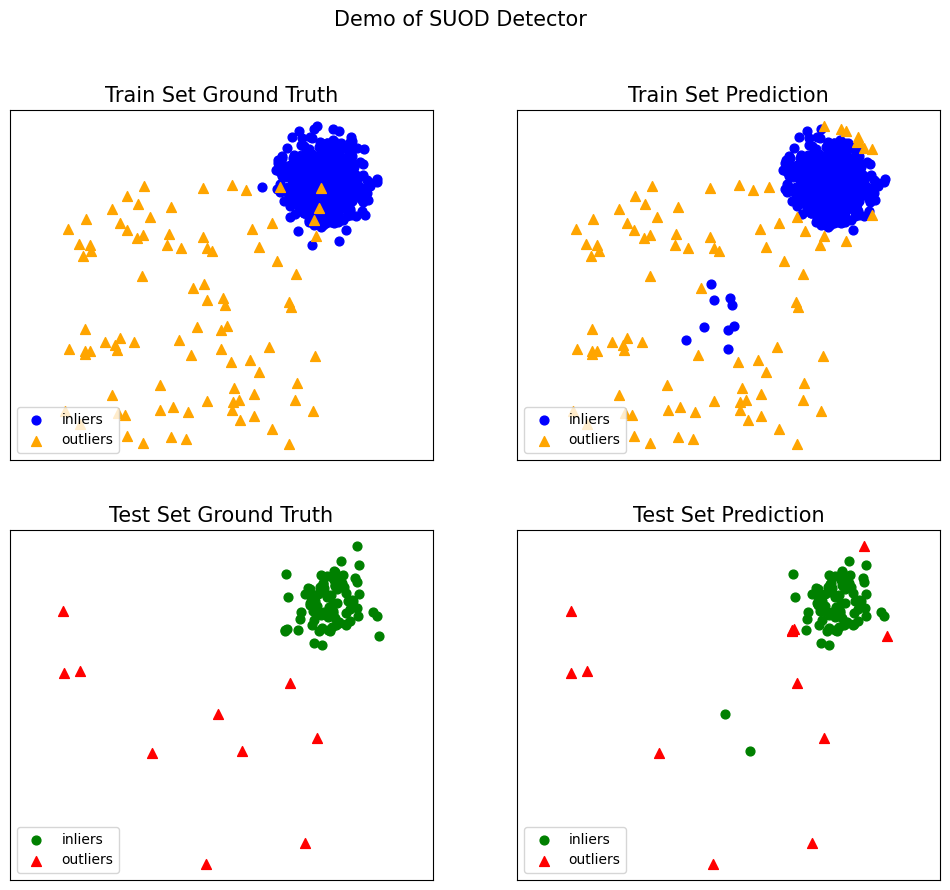

Process took 4.687921047210693 seconds. 


In [2]:
PRINT_DETECTOR_INFO = False                   # Set this to True to print the detectors parameters

start = time.time()
if __name__ == "__main__":
    contamination = 0.1                        # Percentage of outliers
    n_train = 900                              # Number of training points
    n_test = 100                               # Number of testing points

    # Generate synthetic data
    X_train, X_test, y_train, y_test = generate_sample_data(
        n_train=n_train, n_test=n_test, n_features=2, contamination=contamination, random_state=42
    )

    # Define detector configurations
    detector_configs = [
        {'detector': LOF, 'params': {'n_neighbors': 15}},
        {'detector': LOF, 'params': {'n_neighbors': 20}},
        {'detector': LOF, 'params': {'n_neighbors': 25}},
        {'detector': LOF, 'params': {'n_neighbors': 35}},
        {'detector': COPOD, 'params': {}},
        {'detector': IForest, 'params': {'n_estimators': 100}},
        {'detector': IForest, 'params': {'n_estimators': 200}},
    ]

    # Initialize detectors
    detector_list = initialize_detectors(detector_configs)

    if PRINT_DETECTOR_INFO:
        print(detector_list)

    # Train SUOD
    clf = train_suod(X_train, detector_list, n_jobs=1)

    # Get predictions
    y_train_pred, y_train_scores, y_test_pred, y_test_scores = get_predictions(clf, X_train, X_test)

    # Evaluate the model
    evaluate_model('SUOD', y_train, y_train_scores, y_test, y_test_scores)

    # Visualize the results
    visualize_results('SUOD', X_train, y_train, X_test, y_test, y_train_pred, y_test_pred)

end = time.time()

print(f"Process took {end - start} seconds. ")

---

## Real-World Example

We use the heart disease dataset, the same dataset used with the previous algorithm. [check abod algorithm notebook](03-abod-algorithm.ipynb) for more details. Or you can just [visit this link](https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/semantic/HeartDisease/HeartDisease_44.html)

### SUOD System Workflow

To effectively leverage the SUOD System, follow these comprehensive steps:

1. **Data Preprocessing**:
   - **Handle Missing Data**: Impute or remove missing values to ensure data integrity.
   - **Eliminate Duplicates**: Remove duplicate entries to prevent bias in outlier detection.
   - **Encode Categorical Features**: Convert categorical variables to numerical format using techniques like one-hot encoding or label encoding.
   - **Scale Features**: Normalize or standardize features to ensure uniform scale across all input variables, crucial for many outlier detection algorithms.
   - **Dimensionality Reduction** (Optional): Apply techniques like PCA if dealing with high-dimensional data.

2. **SUOD Application**:
   - **Initialize SUOD**: Set up the SUOD framework, specifying the combination of outlier detection algorithms to be used.
   - **Configure Hyperparameters**: Set appropriate parameters for both SUOD and individual detector algorithms.
   - **Train the Model**: Fit the SUOD model to the preprocessed data, utilizing parallel processing and model approximation techniques.

3. **Performance Evaluation**:
   - **Compute Metrics**: Calculate relevant performance metrics such as:
     - Precision at Rank n
     - ROC AUC (Area Under the Receiver Operating Characteristic Curve)
     - Average Precision
   - **Cross-Validation**: Implement k-fold cross-validation to ensure robust performance assessment.

4. **Result Analysis and Interpretation**:
   - **Visualize Outliers**: Create scatter plots or other visualizations to represent detected outliers.
   - **Analyze Outlier Characteristics**: Examine common features or patterns among identified outliers.
   - **Domain-Specific Interpretation**: Contextualize outliers within the specific domain of the dataset.
   - **Comparative Analysis**: Compare SUOD results with traditional single-algorithm approaches if applicable.

5. **Model Refinement** (Optional):
   - **Hyperparameter Tuning**: Adjust SUOD and individual detector parameters based on initial results.
   - **Ensemble Adjustment**: Modify the combination of detectors if certain algorithms underperform.

> **Note**:  
> To reproduce the results in the following example, ensure you have downloaded the required dataset and saved it in an accessible directory. Additionally, verify that all necessary libraries and dependencies are installed in your environment.


### Configuring the SUOD System

In this example, I will be using a diverse set of outlier detection algorithms with varying parameters to configure the SUOD system. The following detectors have been chosen:

- **LOF (Local Outlier Factor)**
  - n_neighbors: 15
  - n_neighbors: 20
  - n_neighbors: 25
  - n_neighbors: 35

- **COPOD (Copula-Based Outlier Detector)**

- **IForest (Isolation Forest)**
  - n_estimators: 25
  - n_estimators: 50
  - n_estimators: 75
  - n_estimators: 100

- **ABOD (Angle-Based Outlier Detector)**
  - n_neighbors: 50

- **KNN (K-Nearest Neighbors)**
  - n_neighbors: 5
  - n_neighbors: 10
 
- **MCD (Minimum Covariance Determinant)**

- **OCSVM (One-Class Support Vector Machine)**

Given the small size of this dataset, I’ve set `n_jobs=1` to run the process on a single core. However, for larger datasets, you can take advantage of parallel computing to speed up the training process by adjusting the `n_jobs` parameter. Set `n_jobs` to a higher value based on your machine’s processing capabilities to optimize performance.

In [3]:
# function to load the dataset
def load_arff_data(filepath):
    """
    Load an ARFF file and return it as a pandas DataFrame.

    Parameters
    ----------
    filepath : str
        Path to the ARFF file.

    Returns
    -------
    data : DataFrame
        The loaded dataset.
    """
    data, meta = arff.loadarff(filepath)
    df = pd.DataFrame(data)
    
    # Convert byte strings to normal strings for categorical variables
    for column in df.select_dtypes([object]).columns:
        df[column] = df[column].str.decode('utf-8')
    
    return df

# Preprocess the dataset
def preprocess_heart_disease_data(df, target_name, scale=False):
    """
    Preprocess the Heart Disease dataset.

    Parameters
    ----------
    df : DataFrame
        The loaded dataset.
    target_name: Str
        The target name.

    Returns
    -------
    X : ndarray
        Feature matrix.
    y : ndarray
        Target vector (outlier labels).
    """
    X = df.drop(columns=[target_name])                                 
    y = df[target_name].apply(lambda x: 1 if x == 'yes' else 0).values

    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X
    
    return X_scaled, y
    
    return X.values, y

def stratify_split_data(X, y, test_size=0.1, random_state=42):
    # Ensure that the test set has a similar distribution of classes as the full dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Check class distribution
    print(f"Training set class distribution: {Counter(y_train)}")
    print(f"Test set class distribution: {Counter(y_test)}")
    
    return X_train, X_test, y_train, y_test

In [4]:
PRINT_DETECTOR_INFO = False                                  # Set this to True to print the detectors parameters
PRINT_DATA_INFO = False

start = time.time()

if __name__ == "__main__":
    # Load and preprocess the dataset
    df = load_arff_data(DATA_PATH)
    X, y = preprocess_heart_disease_data(df, 'outlier')

    if PRINT_DATA_INFO:
        print(df.info())
    # Check overall class distribution
    print(f"Overall class distribution: {Counter(y)}")
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = stratify_split_data(X, y, test_size=0.1, random_state=42)
    
    # Outlier Detector configurations
    detector_configs = [
        {'detector': LOF, 'params': {'n_neighbors': [15, 20, 25, 35]}},
        {'detector': COPOD, 'params': {}},
        {'detector': IForest, 'params': {'n_estimators': [25, 50, 75, 100]}},
        {'detector': ABOD, 'params': {'n_neighbors': 50}},
        {'detector': KNN, 'params': {'n_neighbors': [5, 10]}},
        {'detector': MCD, 'params': {}},
        {'detector': OCSVM, 'params': {}}
    ]

    # Initialize detectors
    detector_list = initialize_detectors(detector_configs)

    if PRINT_DETECTOR_INFO:
        print(detector_list)

    # Train SUOD
    clf = train_suod(X_train, detector_list, n_jobs=1, contamination=0.4444)

    # Get predictions
    y_train_pred, y_train_scores, y_test_pred, y_test_scores = get_predictions(clf, X_train, X_test)

    # Evaluate the model
    evaluate_model('SUOD', y_train, y_train_scores, y_test, y_test_scores)
    
end = time.time()

print(f"Process took {end - start} seconds.")

Overall class distribution: Counter({np.int64(0): 150, np.int64(1): 120})
Training set class distribution: Counter({np.int64(0): 135, np.int64(1): 108})
Test set class distribution: Counter({np.int64(0): 15, np.int64(1): 12})
RandomForestRegressor()





y_train has multiple classes: {np.int64(0), np.int64(1)}
y_test has multiple classes: {np.int64(0), np.int64(1)}

On Training Data:
SUOD ROC:0.6396, precision @ rank n:0.5463

On Test Data:
SUOD ROC:0.5167, precision @ rank n:0.5
Process took 7.312508821487427 seconds.


## Training SUOD as an Unsupervised Problem

In this section, we’ll demonstrate how to train the SUOD (Scalable Unsupervised Outlier Detection) system as an unsupervised learning problem. Unsupervised outlier detection is particularly useful when you don’t have labeled data, meaning you don’t know which instances are inliers or outliers beforehand. The goal is to identify anomalies based solely on the structure and distribution of the data.

### Workflow Overview

1. **Data Preparation**:
    - We start by loading and preprocessing the dataset. Since the task is unsupervised, we don’t need labels for the training data.
    - We’ll use the entire dataset to train the outlier detection model.

2. **Model Initialization**:
    - We define a list of outlier detectors, each with its own set of parameters. These detectors will be used within the SUOD system to identify anomalies in the data.
    - We’ll configure SUOD to work with these detectors in a parallelized manner to speed up the training process.

3. **Training the SUOD Model**:
    - We train the SUOD model using the entire dataset, treating it as an unsupervised problem. The model will learn the patterns in the data and identify instances that deviate significantly from these patterns.

4. **Outlier Detection**:
    - After training, the model predicts which instances in the dataset are outliers. The predicted outliers can then be examined more closely.

5. **Results Analysis**:
    - We’ll review the detected outliers, analyze their characteristics, and visualize the results to understand the model’s performance.

(270, 14)
(270,)
outlier
no     150
yes    120
Name: count, dtype: int64
120
RandomForestRegressor()

************************************************************************
                        Training and Prediction                         
************************************************************************
************************************************************************
                         Displaying Information                         
************************************************************************
Outliers detected: 120 out of 270
Indices of the outliers:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  24  29  32  33  35  37  43  46  48  49  50  52  56  57  59
  60  61  64  67  75  85  87 103 107 110 117 118 119 120 121 122 124 126
 129 130 133 135 137 138 143 144 147 156 159 160 165 167 174 175 176 178
 180 181 184 186 187 188 189 191 194 199 205 206 209 210 211 213 223 226
 227 228 229 235 237 240 243 245 246

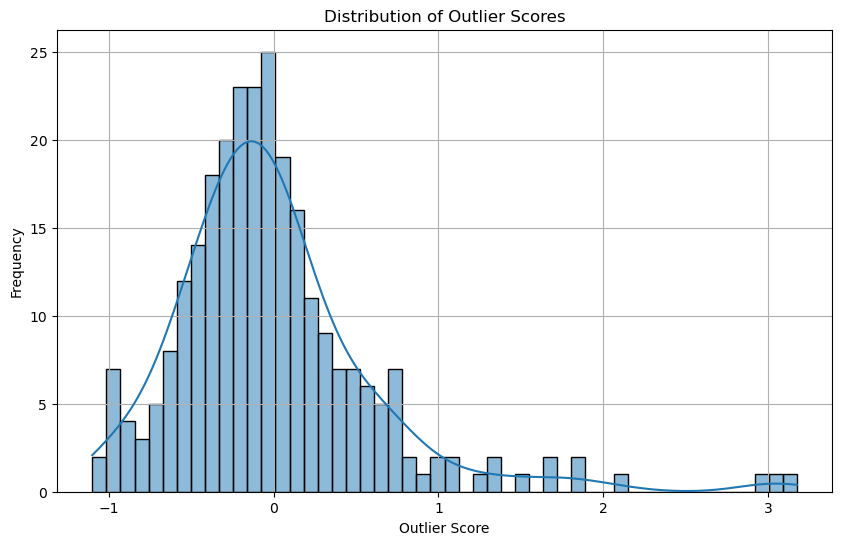

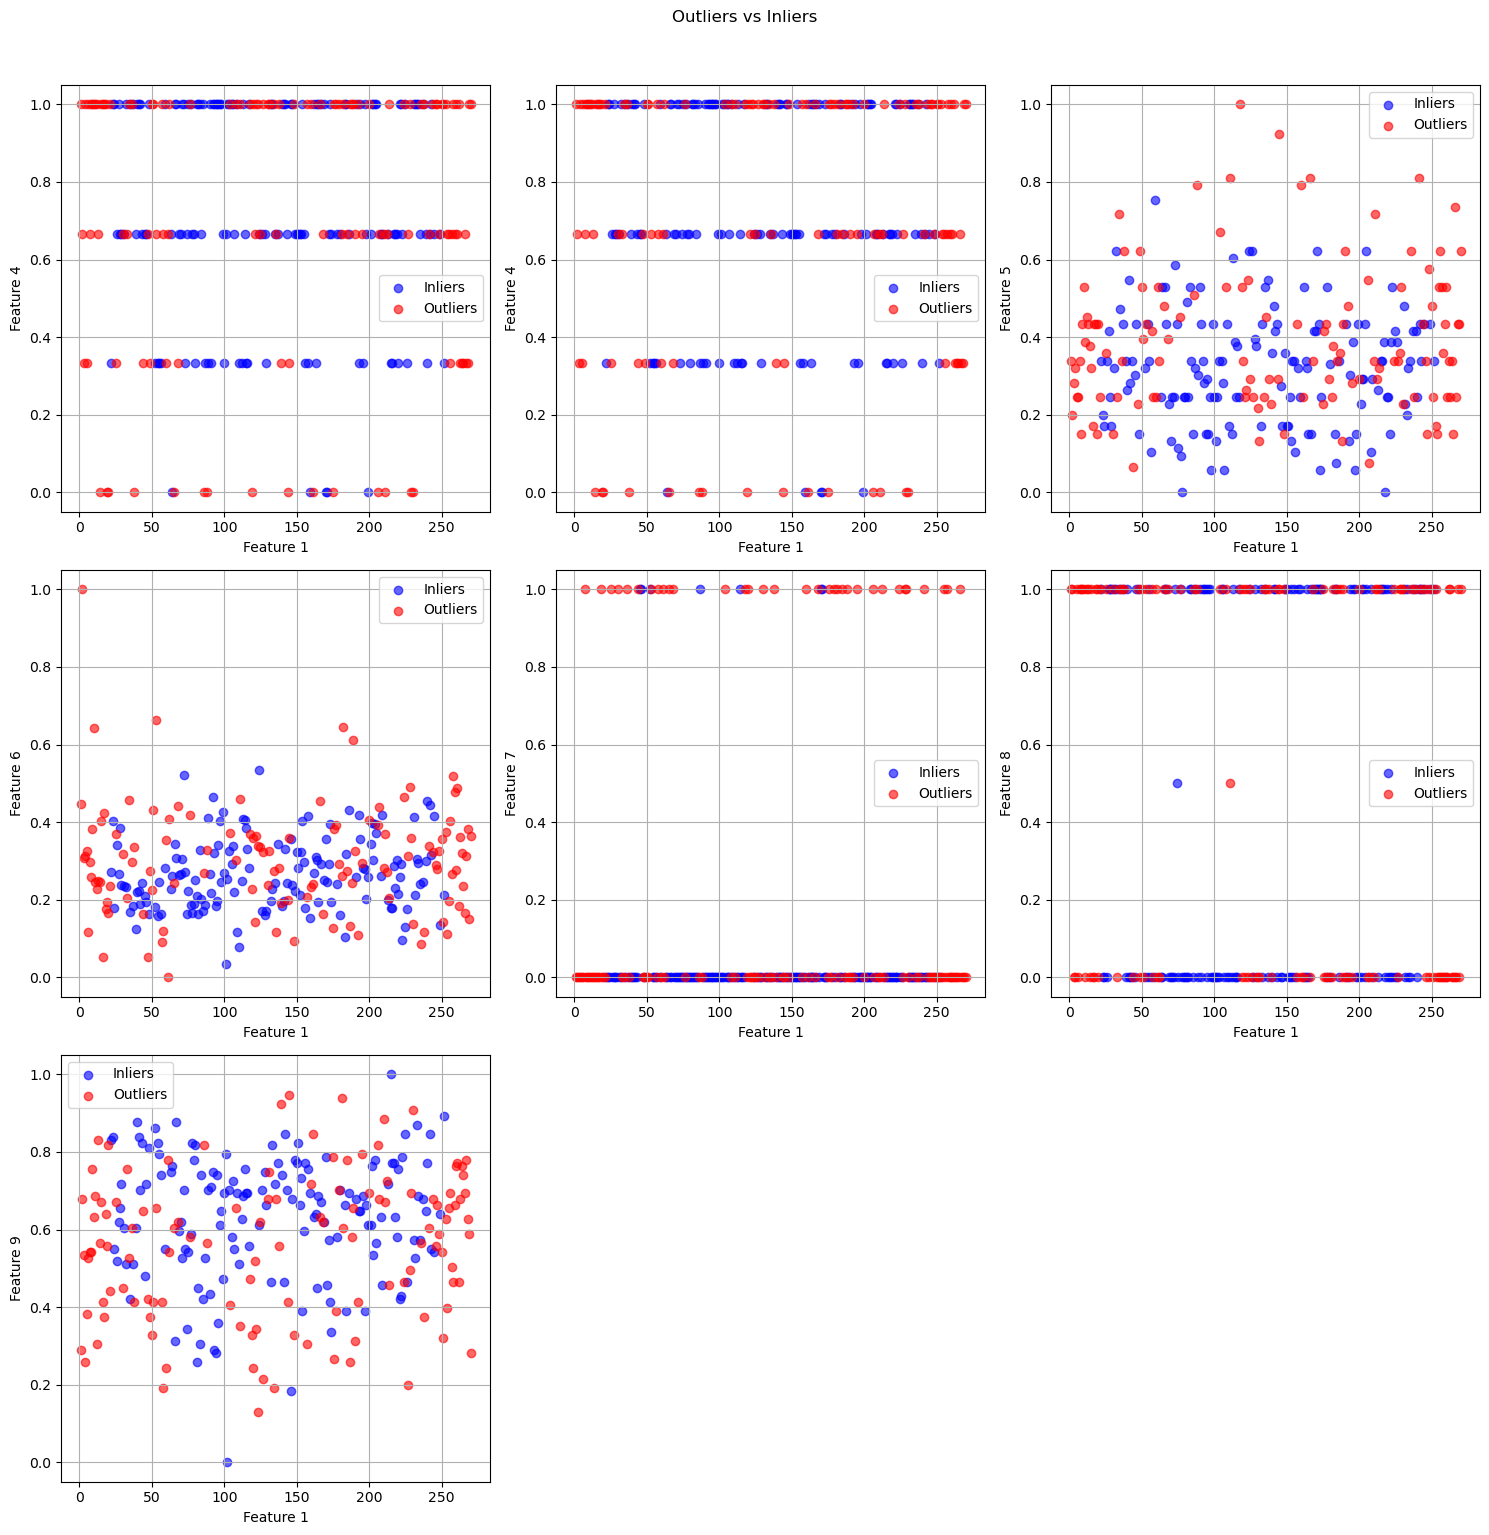

In [5]:
# Load and preprocess the dataset
df = load_arff_data(DATA_PATH)
X, y = preprocess_heart_disease_data(df, 'outlier')
print(X.shape)
print(y.shape)
print(df['outlier'].value_counts())
print(sum(y==1))

# List of detectors configurations
detector_configs = [
    {'detector': LOF, 'params': {'n_neighbors': [15, 25, 50, 75, 100]}},
    {'detector': IForest, 'params': {'n_estimators': [100, 150]}},
    {'detector': COPOD, 'params': {}},
    {'detector': ABOD, 'params': {'n_neighbors': [20, 50, 75]}},
]

# Initialize detectors
detector_list = initialize_detectors(detector_configs)

# Train SUOD
clf, labels = train_suod(X = X, detector_list=detector_list, n_jobs=1, contamination=0.4444, type="unsupervised")


print_banner("*", 72, "Training and Prediction")
# Get predictions
y_pred = labels                # binary labels (0: inliers, 1: outliers)
outlier_scores = clf.decision_scores_ # raw outlier scores


print_banner("*", 72, "Displaying Information")
# You can now analyze the results
print(f"Outliers detected: {sum(y_pred)} out of {len(y_pred)}")

# Getting the outlier indexes
outlier_indices = np.where(y_pred == 1)[0]

# Print the indexes of the outliers
print("Indices of the outliers:")
print(outlier_indices)

# Slice the data to have only the outliers
outliers_only = X.iloc[outlier_indices, :]
print(outliers_only.shape[0])

print_banner("*", 72, "Plotting")

# Plot the distribution of outlier scores
plt.figure(figsize=(10, 6))
sns.histplot(outlier_scores, bins=50, kde=True)
plt.title("Distribution of Outlier Scores")
plt.xlabel("Outlier Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# plot outlier scores
plot_outliers_vs_inliers(X, y_pred = y_pred, plot_features=[3, *range(3, 9)])